# NHL 24 HUT World Championship, a Post Mortem Analysis
## Introduction - What went wrong?

NHL 24 is a game produced by EA Sports. HUT stands for "Hockey Ultimate Team" where you create your own version of an all-star team over time. This was a widely publicized event and required signing up several weeks in advance. I went into it without many expectations. I don't consider my skill level poor, but I know I am not good. These games were long format and an entire game would take about half an hour, using Stanley Cup rules (5v5 OT, no shootout). I played 9 games in the HUT World Championship, and I lost most games by being outscored nearly 6:1. This was a very bad showing on my part.

My motivation is to analyze these data to understand what went wrong and identify strategies for improving my game skill. In general, this is how I approach problem solving. I had some data going into this experiment that might help me discern tangible strategies from improvement. I don't consider myself a "data scientist" these days-- I am just a dude who got put to shame on Xbox and I want to be better next time around. I normally don't use Jupyter, I am kind of set in my ways, but this is a nice way to tell a story using data-- my goal here is to walk through the analysis. I think this is what solving hard issues in 2024 is going to need to look like more regularly - a common sense blend of a little data science, data storytelling, creative problem framing, and business analysis. 

This entire analysis is repeatable and will update with very little effort. I can also pull in all kinds of content.

*When I was just starting my career in Data, I spent a lot of time browsing the content at FiveThirtyEight. Nate Silver is a legend and I believe that taking an abstract issue like getting lit up in video games can have real world learnings if you distill them right.*

##### Import Packages 
This is how you import packages in Python. Most of these are preloaded in the anaconda distribution, which I have helped dozens of people get familar with over my career.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, Normalize
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from pandasql import sqldf
from IPython.display import display, HTML, Image
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
from datetime import datetime as dt


def sqlQuery(string):
    '''
    Parameters
    ----------
    string : String of SQL query using dataframes in document
    Returns
    -------
    SQL Query
    '''
    return sqldf(string, globals())

##### Get Data
I have three types of game data I am going to use. I have data from the World Championship games, I have data from my season leading up (shorter format games), and I have some shot data from 2 particularly bad games that I transcribed for this purpose.

In [49]:
#get data 
net_pic = r"C:\Users\calholt\Documents\Callaway\NHL24\Data\CleanNet.PNG"
path = r"C:\Users\calholt\Documents\Callaway\NHL24\Data\NHL Scores 01162024-2.xlsx"
overload_pic = r"C:\Users\calholt\Documents\Callaway\NHL24\Data\Overload Strat Pic.PNG"
breakout = r"C:\Users\calholt\Documents\Callaway\NHL24\Data\up-hockey-breakout.jpg"
pp_strat = r"C:\Users\calholt\Documents\Callaway\NHL24\Data\PP Strat.PNG"
shot_net = r"C:\Users\calholt\Documents\Callaway\NHL24\Data\ShotNet.PNG"
offensive_zone = r"C:\Users\calholt\Documents\Callaway\NHL24\Data\Shooting Areas.PNG"
offensive_zone_blank = r"C:\Users\calholt\Documents\Callaway\NHL24\Data\Offensive Zone Blank.PNG"
realshots = r"C:\Users\calholt\Documents\Callaway\NHL24\Data\ShotMapReal.PNG"
ppzones = r"C:\Users\calholt\Documents\Callaway\NHL24\Data\PPZone.PNG"

shots = pd.read_excel(path, sheet_name = 'Shot Raw Data')
regular = pd.read_excel(path, sheet_name = 'Data', header = 5)
wc = pd.read_excel(path, sheet_name = 'WC Data', header = 5)
players = pd.read_excel(path, sheet_name = 'Team Info', header = 5)
shot_area = pd.read_excel(path, sheet_name = 'Shooting Areas')

#cut out bad data 
wc.drop(columns = ['Unnamed: 17','SMA'], inplace = True)
regular.drop(columns = ['Unnamed: 12','SMA'], inplace = True)
shots.fillna(0, inplace = True)

## Meet the Team
Let's meet my team. EA has been criticized on their games being a pay to play (*play well*) structure. I wont comment on that, but what I will say is that I have spent no money on acquiring good players and that shows. My team was certainly below average in terms of skill. Nonetheless, it is many of my favorite players and if this were a real team, I think they would be an absolute wagon with tons of fan appeal. 

One thing that stands out here to me are my F3 and F4 lines being lower skill by several points. If you consider 90+ as really good, I have two lines which run at around an 80 skill level. 


In [3]:
# using SQL because its easier and faster for me. I don't like pandas groupby as great as pandas is. 
team = sqlQuery("""
            select 
                Player
                ,Line
                ,Position
                ,Shoots
                ,Style
                ,min(Ovr) as Skill
            from players
            group by line, Player, Style
            order by line asc
            """)
team

Player Line       Position Shoots                 Style  Skill
0         Quinn Hughes   D1  Right Defense   Left  Offensive Defenseman     85
1           Seth Jones   D1   Left Defense  Right    Two Way Defenseman     89
2          Brock Faber   D2   Left Defense  Right    Two Way Defenseman     86
3         John Carlson   D2  Right Defense  Right    Two Way Defenseman     83
4             Adam Fox   D3   Left Defense  Right  Offensive Defenseman     84
5         Drew Doughty   D3  Right Defense  Right    Two Way Defenseman     83
6        Alex Ovechkin   F1      Left Wing  Right                Sniper     85
7        Connor Bedard   F1         Center  Right                Sniper     86
8           The Nasher   F1     Right Wing   Left             Playmaker     87
9       David Pastrnak   F2      Left Wing  Right                Sniper     86
10     Nikita Kucherov   F2     Right Wing   Left                Sniper     92
11       Trevor Zegras   F2         Center   Left             Playmaker     85
12        Dany Heatley   F3     Right Wing   Left                Sniper     80
13        Mitch Marner   F3         Center  Right             Playmaker     77
14       Patrick Laine   F3      Left Wing  Right                Sniper     84
15       Claude Ciroux   F4         Center  Right             Playmaker     81
16         Taylor Hall   F4      Left Wing   Left             Playmaker     82
17    William Nylander   F4      Left Wing  Right             Playmaker     83
18  Andrei Vasilevskiy   G1         Goalie   Left                Hybrid     84
19    Jacob Markstrorm   G2         Goalie   Left                Hybrid     84

In [38]:
team.Skill.mean()

84.3

In [37]:
team[['Line','Skill']].groupby('Line').mean()

Skill
Line           
D1    87.000000
D2    84.500000
D3    83.500000
F1    86.000000
F2    87.666667
F3    80.333333
F4    82.000000
G1    84.000000
G2    84.000000

There isn't really one scorer that I count on more than others. Ovechkin has the most points followed by Nasher and Pastrnak. My D men also rack up many points. My team is all Playmakers and Snipers and my defense is offensively biased. 

While my team is all gas and no breaks, were pretty average on a good day in terms of skill. My only player in the 90's range is a new addition. Most of my opponents had multiple players 90+ skill. Overall, my teams average is an 84 skill.


## Our Strategy
Like I said my team is really set up to be Snipers, meaning we are going to try and put accurate shots on net to score. My team is set up to look for a shot on the weak side (where the defenses attention is shifted). The best player in the world (Alex Ovechkin) is about to surpass Wayne Gretzky for goal scoring, a milestone thought impossible to surpass, from standing at the top of the left circle and hammering shots when the play is on the right side of the ice, and no one is looking at him. This bias towards shooting is evident in both my full strength and power play approach.

In [5]:
iframe_code = """
<iframe src="https://giphy.com/embed/3iyVPUiICrqJtmv00I" width="480" height="270" frameBorder="0" class="giphy-embed" allowFullScreen></iframe>
<p><a href="https://giphy.com/gifs/nhl-caps-capitals-3iyVPUiICrqJtmv00I">via GIPHY</a></p>
"""

# Displaying the HTML content in the Jupyter Notebook
display(HTML(iframe_code))


#### Even Strength
My best two lines run an overload strategy. The overload strategy in even-strength situations is about creating advantages by strategically positioning players and exploiting defensive weaknesses. It requires effective communication, player movement, and an understanding of the opponent's defensive structure. Coaches may implement specific systems or plays to encourage an overload in certain area of the ice.

My bottom two lines Crash the Net, meaning they take the puck hard to the net to see what happens. They end up shooting a lot though also just like lines 1 and 2. This could help them with goal production and lucky, dirty goals.
.

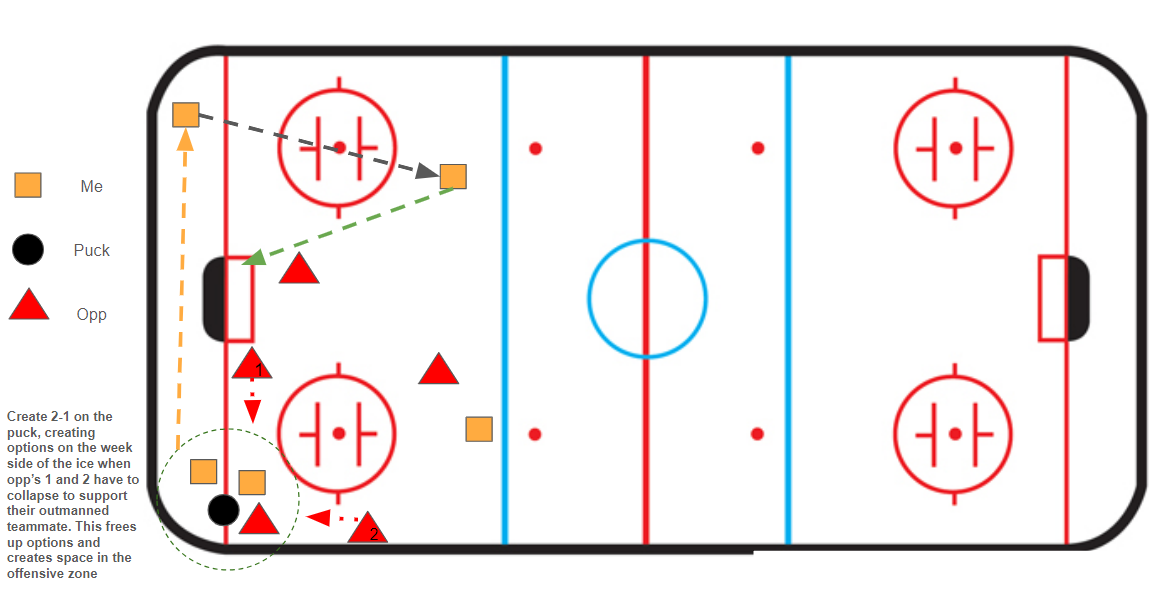

In [6]:
display(Image(filename=overload_pic))

#### Breakout

When I am stuck in my defensive zone, I try to get out of the zone by having the center swing high and catch a long breakout pass or the weak side wing go even higher. This is pretty standard 14 year old level hockey stuff but works for me. This is because my puck possession game is weak and the less I can have the puck skating though the neutral zone, the better.

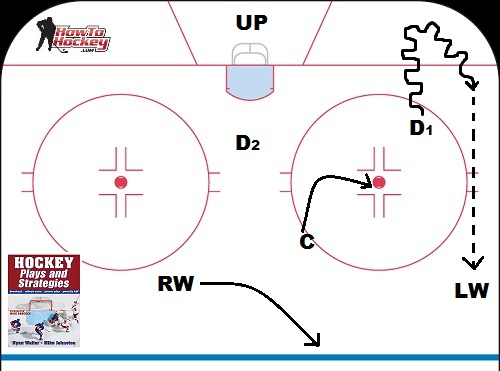

In [7]:
display(Image(filename=breakout))

#### Powerplay

If you're new to hockey - a power play is the result of what happens with the other team takes a penalty. You get penalties in hockey for doing things that you shouldn't have. Most actions involve some level of violence (not like a false start in football). As a result, the guilty player gets sent to the penalty box for 2 minutes while their team then gets to play with one less player for a while. If you're unlucky enough to draw another penalty, it can go as low as 5-3 but will not go below 3 players - time will just begin to be appended to the penalty time the team in the box is trying to kill. Penalties come in 2, 5, and 10 minute varieties which depend on the severity of the call. 5- and 10-minute penalties are major penalties and luckily they do not happen that often because usually it means something pretty bad happened and safety was a legitimate concern. On major penalties, if you score the power play continues whereas on minor penalties, once the team on the power play scores, the power play ends irrespective of how much time is left.

I use an Umbrella strategy in the power play. Because of all of the weapons I have at my disposal, I don't need to favor a particular side of the ice, but ideally, we want a pass to shift the play and open a scoring lane off to the weak side. My second power play unit is very similar in makeup and approach.

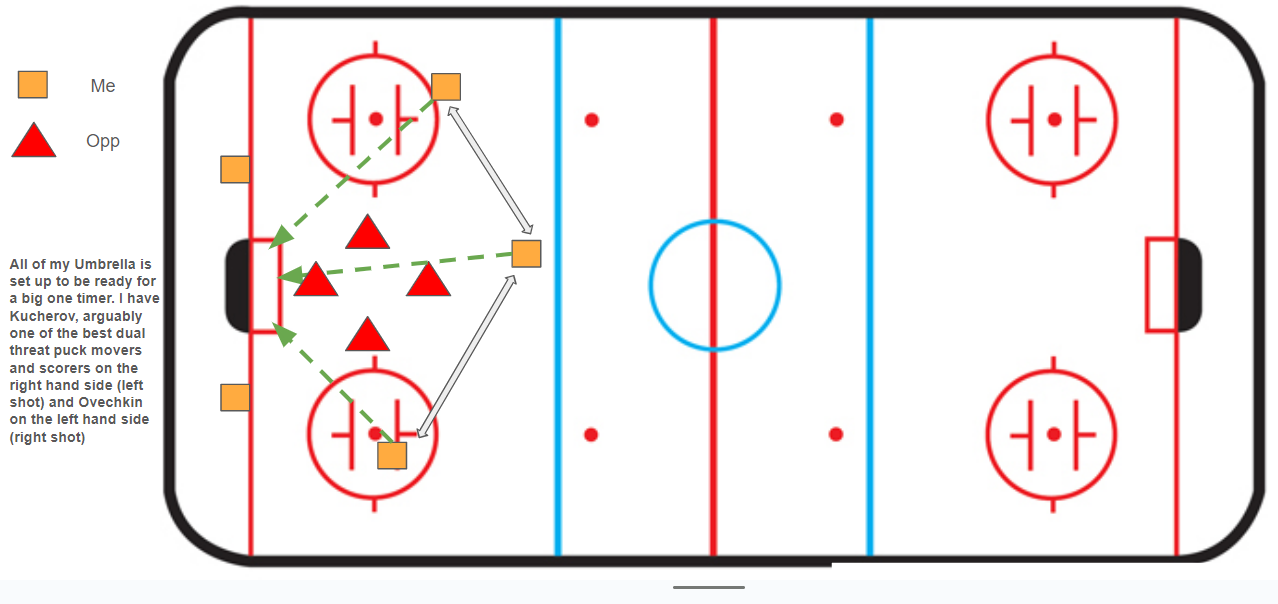

In [8]:
display(Image(filename=pp_strat))

## Momentum Going Into WC
Let's look at how I was doing going into the tournament. These data come from games that were in a 2-minute period format, so they were quick games. Since starting my data tracking, my record is 20-24-4.

In [9]:
pd.DataFrame(regular.Outcome.value_counts())

count
Outcome       
W           21
L           20
OTL          6
SOL          5
OTW          2

#### Scoring and Shooting

Let's look at how I was scoring over time

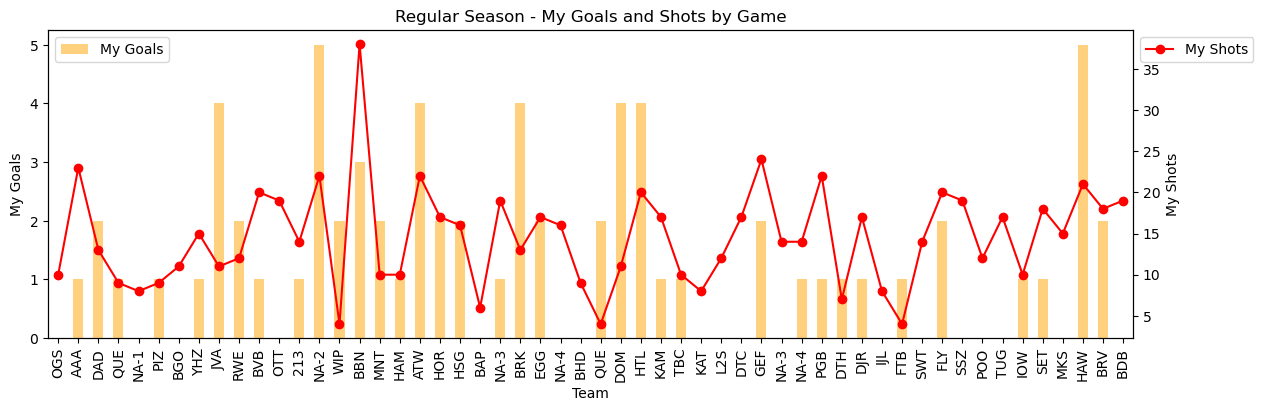

In [10]:
ax1 = regular.plot(kind = 'bar', y = 'MNA', x = 'Team', figsize = (14,4), color = 'orange', label = 'My Goals', alpha = .5)
ax2 = ax1.twinx()
regular.plot(kind='line', y='MNA Shots', ax=ax2, color='red', marker='o', label='My Shots')
ax1.set_ylabel('My Goals')
ax2.set_ylabel('My Shots')
plt.title('Regular Season - My Goals and Shots by Game')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

Lets think a little harder about this. What does average look like in this situation with shots and goals? A regression would show the influence shots have on top of goals for every incremental shot (beta coeff), beyond the starting point (y int).

In [11]:
# Specify the formula using the Q() function for the column with spaces
formula = 'MNA ~ Q("MNA Shots")'
# Create matrices for the model
y, X = dmatrices(formula, data=regular, return_type='dataframe')
# Fit the linear regression model
model = sm.OLS(y, X).fit()
formatted_formula = f"{model.model.endog_names} = {model.params[0]:.2f} + {model.params[1]:.2f} * {model.model.exog_names[1]}"
print("Regression Formula:")
print(formatted_formula)
# Display the regression results
print(model.summary())

Regression Formula:
MNA = 0.33 + 0.07 * Q("MNA Shots")
                            OLS Regression Results                            
Dep. Variable:                    MNA   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     5.259
Date:                Wed, 17 Jan 2024   Prob (F-statistic):             0.0259
Time:                        19:30:17   Log-Likelihood:                -91.718
No. Observations:                  54   AIC:                             187.4
Df Residuals:                      52   BIC:                             191.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

This is very interesting. I should note that there are some concerns around the statistical significance of my model. I am not going to worry about this. It might not have the best predictive value (p) or explain much of the variance (r^2), but I am really just trying to draw a trend line and that’s something here I can just look at and say 'yup, looks right'. I think data people can sometimes get hung up on this and lose sight of the goal.

In [12]:
print(formatted_formula)

MNA = 0.33 + 0.07 * Q("MNA Shots")


and do the following:

In [13]:
beta_coeff = .0625

print(int(100/(beta_coeff * 100)), " Shots needed per goal")

16  Shots needed per goal


Ok so that's pretty bad which explains the following chart of my opponents and I:

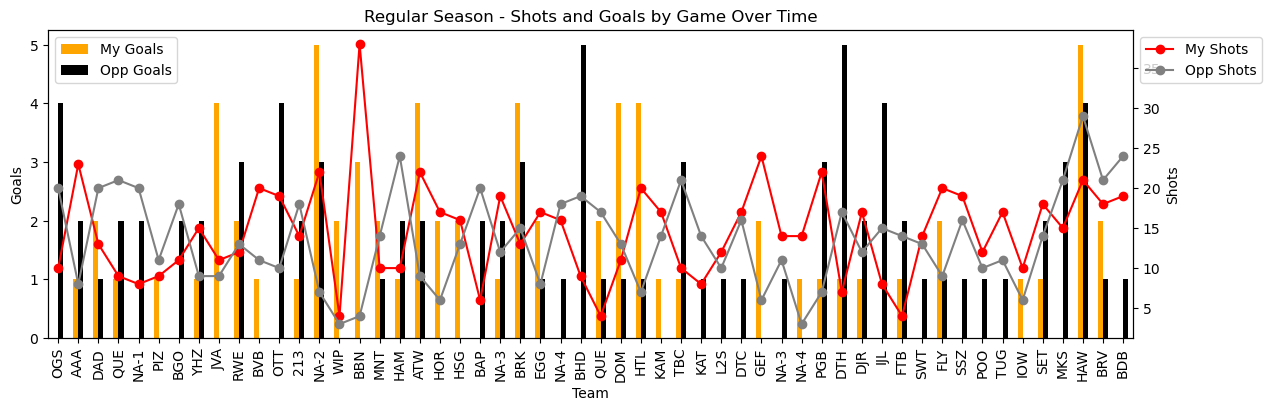

In [14]:
ax1 = regular.plot(kind = 'bar', y = ['MNA','Opp'], x = 'Team', figsize = (14,4), color = ['orange','black'], label = ['My Goals','Opp Goals'])
ax2 = ax1.twinx()
# Plot the second variable on the secondary y-axis
regular.plot(kind='line', y=['MNA Shots', 'Opp Shots'], ax=ax2, color=['red', 'grey'], marker='o', label=['My Shots', 'Opp Shots'])
# Set labels and legend
ax1.set_ylabel('Goals')
ax2.set_ylabel('Shots')
plt.title('Regular Season - Shots and Goals by Game Over Time')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# Show the plot
plt.show()

## Scoring Insights

#### Shooting Accuracy and Shot Choice

I am very happy I was able to do this. This really resonates with my general perspective on where we sit today in a business landscape. Valuable data is out there but it is hard to get. To get shooting data, I took pictures from 2 games during the WC. I then broke the net up into 36 zones and counted shots and goals. This looked like this:

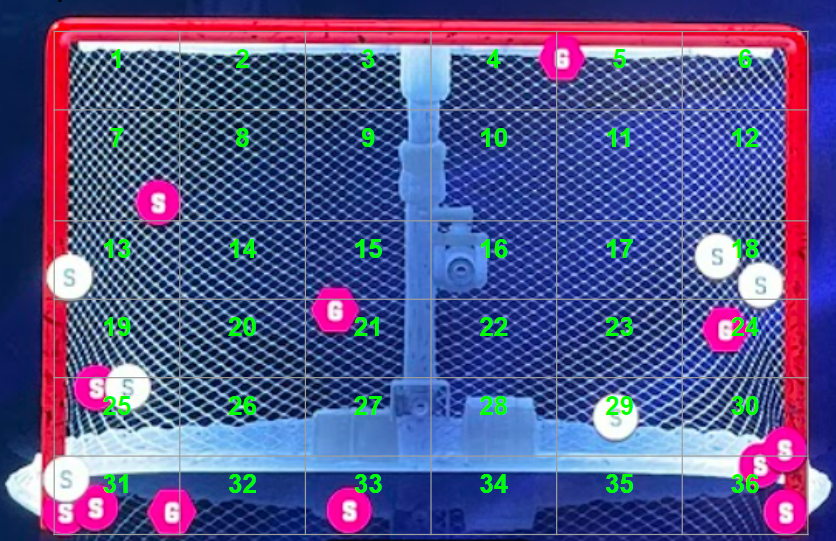

In [15]:
display(Image(filename=shot_net))

This was really annoying to do and I am sure AI could be applied here. I bet I could figure this out with a little more time spent. A hockey net is 72 inches wide by 48 inches high. This means each zone is about:

In [39]:
print(round((48*72)/36), ' Square inches')

96  Square inches


Most pro players can hit targets that size. I bet I could even hit some of those under the right circumstances.

In [40]:
def getShotMap(dataframe, col, scheme, style):
    grid_values = dataframe[col].values.reshape((6, 6))
    background_img = plt.imread(net_pic)
    fig, ax = plt.subplots(figsize=(8, 5))  # Adjust the figsize if needed
    extent_matrix = (0, 6, 0, 6)
    extent_image = (0, 6, 0, 6)  # Match the matrix size
    cmap = plt.get_cmap(scheme)
    im = ax.imshow(grid_values, cmap=scheme, interpolation=style, vmin=0, vmax=np.max(dataframe[col]), extent=extent_matrix)
    for i in range(6):
        for j in range(6):
            #the next line really caught me up. The matrix was reading in backwards and my labels were shifted down by 1. This caused the coloring to
            #look off when really it was the numbers. This is why I always tell my teams to tripple check work they think they feel really good about
            #you usually end up learning something valuable 
            ax.text(j+.5, 5.5 - i, f'{grid_values[i, j]:.2f}', ha='center', va='center', color='black', fontsize=8) #this really caught me up
    ax.imshow(background_img, extent=extent_image, aspect='auto', zorder=1, alpha=0.5)
    cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0.1)
    ax.axis('off')
    ax.set_title(col)
    return plt.show()

Lets make some hard metrics:

In [41]:
# shooting
agg_shots = shots.drop(columns = ['Photo']).groupby('Location').sum()
agg_shots.reset_index(inplace = True)
agg_shots['Shots'] = agg_shots['Opp Shots'] + agg_shots['MNA Shots']
agg_shots['Total Goals'] = agg_shots['Opp G'] + agg_shots['MNA G']
agg_shots['Total Shots'] = agg_shots['Shots'] + agg_shots['Total Goals']
agg_shots['Shooting PCT'] = agg_shots['Total Goals']/ agg_shots['Total Shots']
agg_shots['Shot Dist'] = agg_shots['Total Shots'] / agg_shots['Total Shots'].sum()
agg_shots['Goal Dist'] = agg_shots['Total Goals'] / agg_shots['Total Goals'].sum()

Lets think about this for a second. We have the percent chance that a puck goes into the net in for each zone. We also have the shot distribution, which withholding the ability to aim, is the distribution of where shots will go on net. If we combine these two things, we will be able to get a "Goal Yield" (which I just like the name of) for each location on the net. We can then assume that any 1 puck thrown on net will be subject to the combine goal yield of all 36 zones.

In [55]:
agg_shots['Goal Yield/100'] = (agg_shots['Shot Dist'] *agg_shots['Shooting PCT'])*100
agg_shots.fillna(0, inplace = True)

We basically know that for every random 1000 shots we will gain the sum of the goal yeild:

In [57]:
print(round(agg_shots['Goal Yield/100'].sum(),2), 'Per 100 Shots')
print(round(100/agg_shots['Goal Yield/100'].sum(),2), 'Shots per one goal')
print('Every one shot will get me',1/round(1000/agg_shots['Goal Yield/100'].sum(),2),'goals on average over time')

21.43 Per 100 Shots
4.67 Shots per one goal
Every one shot will get me 0.021427040925648167 goals on average over time


You might be saying "your shooting percentage isn't 21%... you wouldn't be doing this exercise if you were that good". You're right. This data is from my opponents and I both - and honestly - due to how bad I was beaten, most of it is my opponents. Lets look at how shot placement influences scoring:

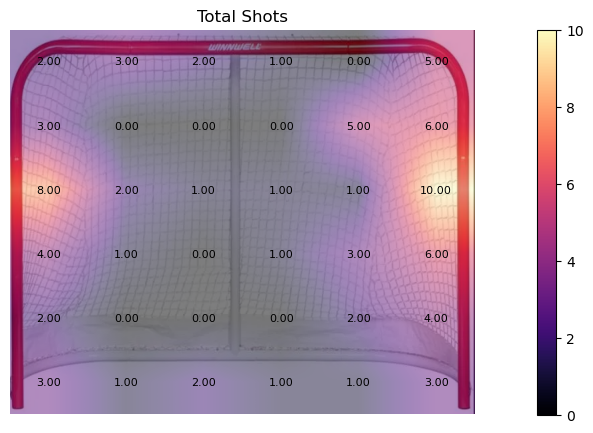

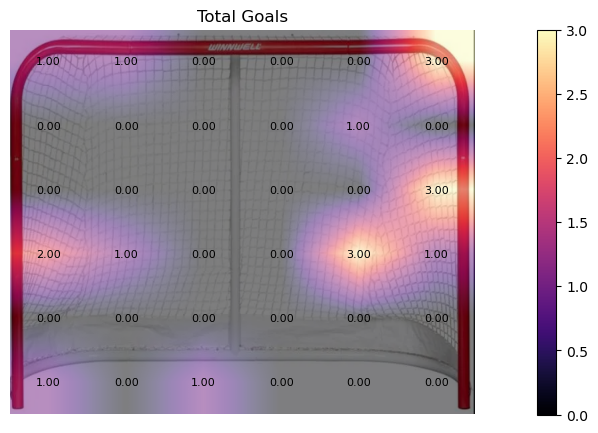

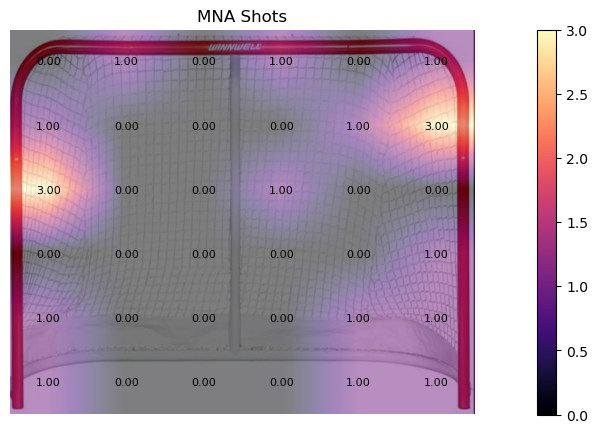

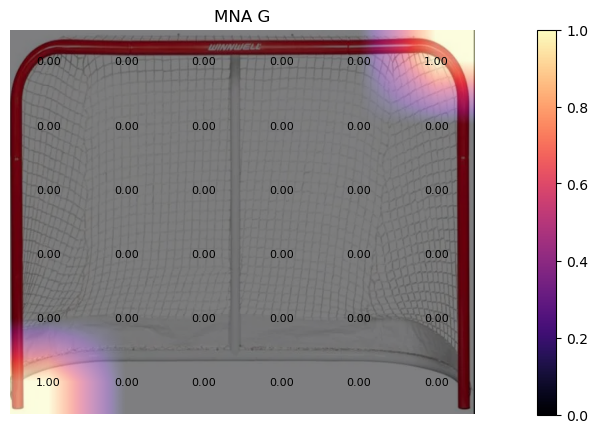

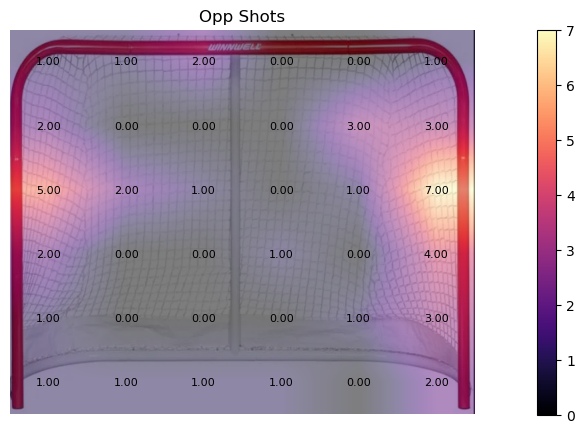

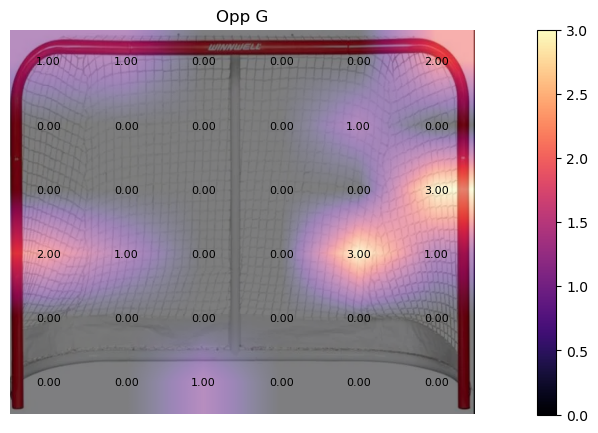

In [21]:
for value in ['Total Shots','Total Goals','MNA Shots', 'MNA G', 'Opp Shots', 'Opp G']:
    getShotMap(agg_shots, value, 'magma', 'bilinear') #bilinear

Let's look at some invented KPIs

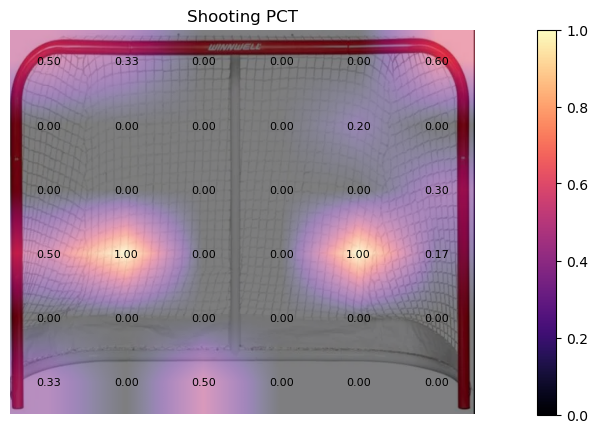

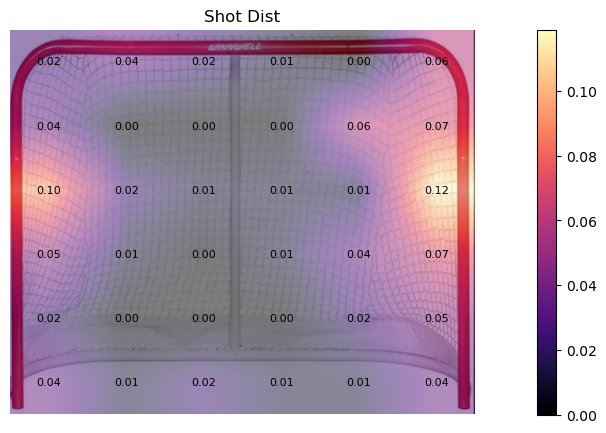

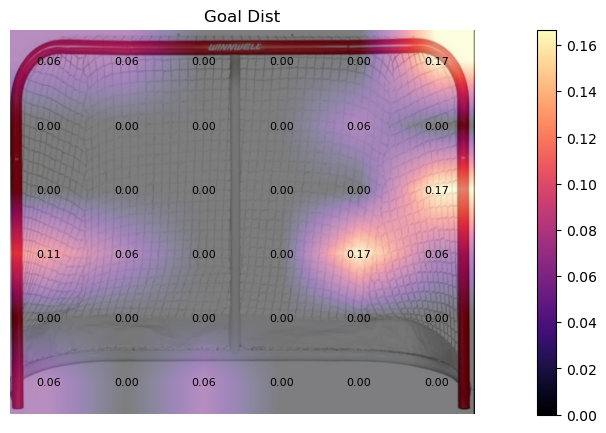

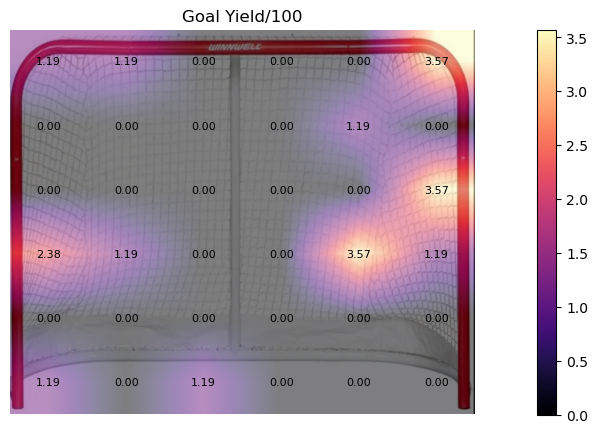

In [58]:
for value in ['Shooting PCT','Shot Dist', 'Goal Dist', 'Goal Yield/100']:
    getShotMap(agg_shots, value, 'magma', 'bilinear') #bilinear

What all of this tells me is that for both my opponents and I, the best places to try and put the puck are mid blocker side, mid glove side, top left, and low glove side. I never would have thought that. So now the question is how do we implement a plan to get those shots on net within my existing strategy?

One interesting thing I know that wouldn't show up in the data is that my controller and hand placement might be part of the reason why I had a difficult time going top shelf, which not only is the pinnacle of a "snipe" but my data show is really productive. I was using big joysticks on my controller, and I think that limited my ability to aim. I know that this sounds like an excuse… but I am trying some new controller settings in my execution phase. This is one of the things I like to tell my data teams – just because something might not show up in our data doesn’t invalidate other outside knowledge or common sense.


#### Shooting Areas

My approach to discerning best areas on the ice to take shots also follows a grid. By breaking the offense zone into 18 parts we are able to have a good amount and specificity when referring to locations while not creating too much work for those transcribing the data (me). This is often something orginizations need to think about, or at least should think about when it comes to data. How much is too much? Whats the optimal level of grainularity that gets me what I need without wasting time? 

In [71]:
#dims of an offensive zone
w = 85
l = 64
s = round((w*l)/18) #
print (s,'square feet in each zone')
print('roughly a square with sides of ',round(np.sqrt(s)), 'feet')

302 square feet in each zone
roughly a square with sides of  17 feet


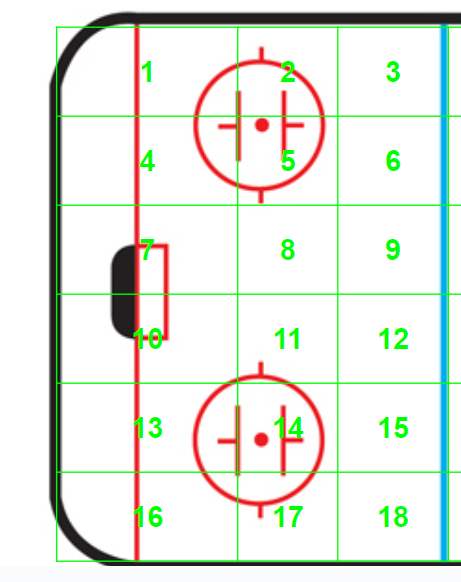

In [23]:
display(Image(filename=offensive_zone))

I then took pictures of the shot chart from several games and begun to transcribe these data into my data set. This was very tedious, and I would have done this differently in hindsight. Again, this is a prime task where AI could be applied and the average person could figure out how to do that in a couple hours.

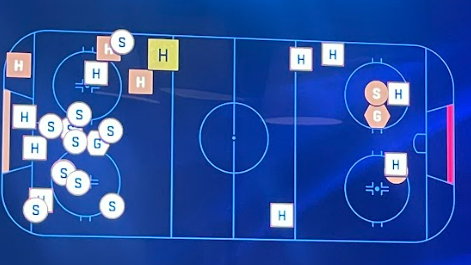

In [24]:
display(Image(filename=realshots))

In [78]:
# shooting
agg_shots_areas = shot_area.drop(columns = ['Team']).groupby('Location').sum()
agg_shots_areas.fillna(0,inplace = True)

agg_shots_areas['Shots'] = agg_shots_areas['Opp Shots'] + agg_shots_areas['MNA Shots']
agg_shots_areas['Total Goals'] = agg_shots_areas['Opp G'] + agg_shots_areas['MNA G']
agg_shots_areas['Total Shots'] = agg_shots_areas['Shots'] + agg_shots_areas['Total Goals']
agg_shots_areas['Shooting PCT'] = agg_shots_areas['Total Goals']/ agg_shots_areas['Total Shots']
agg_shots_areas['Shot Dist'] = agg_shots_areas['Total Shots'] / agg_shots_areas['Total Shots'].sum()
agg_shots_areas['Goal Dist'] = agg_shots_areas['Total Goals'] / agg_shots_areas['Total Goals'].sum()
agg_shots_areas['Goal Yield/100'] = (agg_shots_areas['Shot Dist'] *agg_shots_areas['Shooting PCT'])*100

agg_shots_areas.fillna(0,inplace = True)
agg_shots_areas.reset_index(inplace = True)

Having this be flipped on its side was super annoying and I regret not fixing that right away. Because my data set now reflects this horizontal approach, I can’t just rotate viz (I could, but then I need to rotate all text 90 degrees and it just becomes messy). Let’s avoid this headache. Renumber the zones so that flipping the visual is easier and I won't need to rotate text later. I am not comfortable changing the raw data in its actual document because I know it’s right, just inconvenient. This is why I like python - I worked hard to collect these data and despite having messed up slightly, I will be able to quickly fix and be able to see the process I implement to fix the small issue. This is just a normal data hiccup. It’s sort of a matter of preference, but I would always recommend backing up your original data rather than overwriting it. That’s what I will do here.

In [73]:
# there are better ways to do this transformation but I was excited to see the results so just moved fast
def newZones(value):
    if value == 16:
        return 1
    elif value == 13:
        return 2
    elif value == 10:
        return 3
    elif value == 7: 
        return 4
    elif value == 4:
        return 5
    elif value == 1:
        return 6
    elif value == 17:
        return 7
    elif value == 14:
        return 8
    elif value == 11:
        return 9
    elif value == 8:
        return 20
    elif value == 5:
        return 11
    elif value == 2:
        return 12
    elif value == 18:
        return 13
    elif value == 15:
        return 14
    elif value == 12:
        return 15
    elif value == 9:
        return 16
    elif value == 6:
        return 17
    elif value == 3:
        return 18
    else:
        pass

agg_shots_areas['new_zone'] = [newZones(x) for x in agg_shots_areas.Location]

In [46]:
agg_shots_areas[['Location','new_zone']].reset_index() #lets check our work. Always check our work even when were sure it worked right

index  Location  new_zone
0       0         1         6
1       1         2        12
2       2         3        18
3       3         4         5
4       4         5        11
5       5         6        17
6       6         7         4
7       7         8        20
8       8         9        16
9       9        10         3
10     10        11         9
11     11        12        15
12     12        13         2
13     13        14         8
14     14        15        14
15     15        16         1
16     16        17         7
17     17        18        13

In [79]:
def getZoneMap(dataframe, col, scheme, image_path, style):
    grid_values = dataframe[col].values.reshape((3, 6))
    background_img = plt.imread(image_path)
    # Create subplots with 33% vertical shrinkage
    fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figsize if needed
    # Set the extent to match the matrix (adjust vertical extent as needed)
    extent_matrix = (0, 6, 0, 3)
    extent_image = (0, 6, 0, 3)  # Match the matrix size
    cmap = plt.get_cmap(scheme)
    im = ax.imshow(grid_values, cmap=scheme, interpolation= style, vmin=0, vmax=np.max(dataframe[col]), extent=extent_matrix)
    # Add text annotations for each cell with floating-point labels
    for i in range(3):
        for j in range(6):
            ax.text(j + 0.5, 2.5 - i, f'{grid_values[i, j]:.2f}', ha='center', va='center', color='black', fontsize=8)
    ax.imshow(background_img, extent=extent_image, aspect='auto', zorder=1, alpha=0.5)
    cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0.1)
    # Hide axes for better visibility
    ax.axis('off')
    ax.set_title(col)
    return plt.show()


This visual is just about right. Realistically, zones 1-6 (top row) should not exist below the goal line so those zones should be halved, but its representative. 

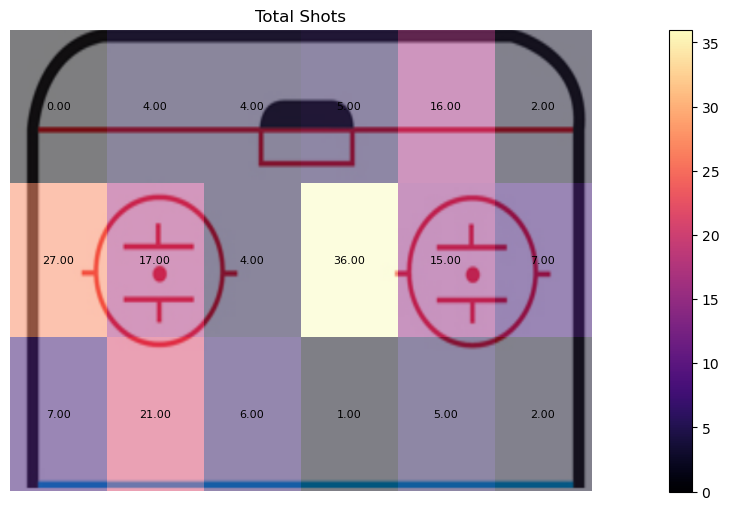

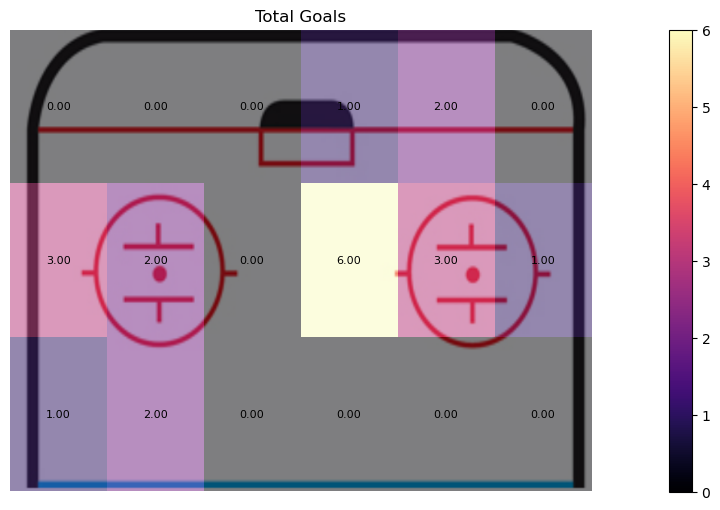

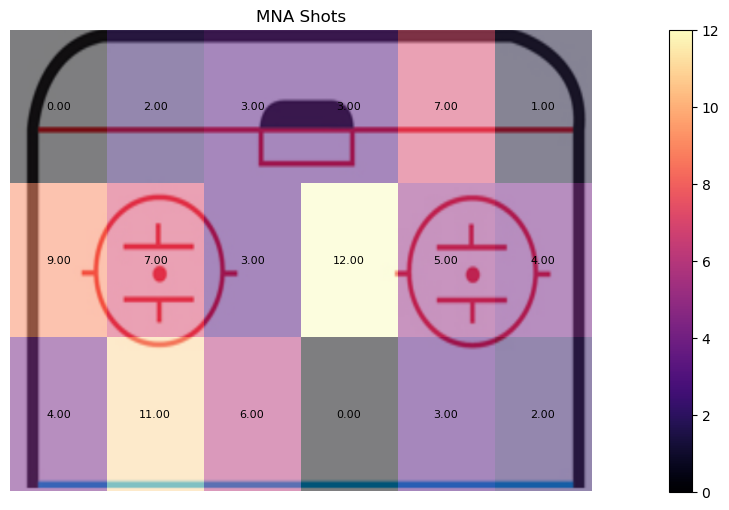

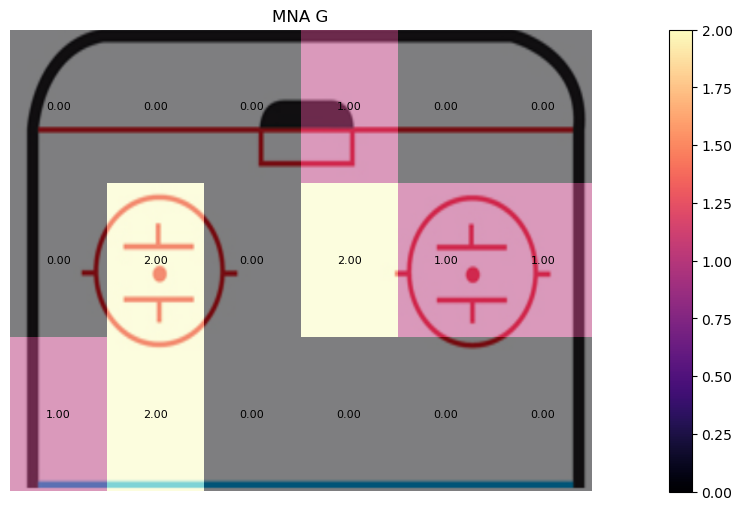

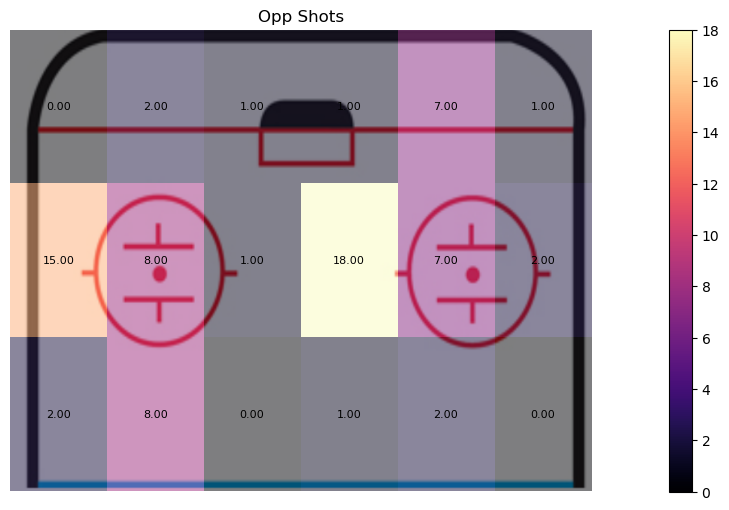

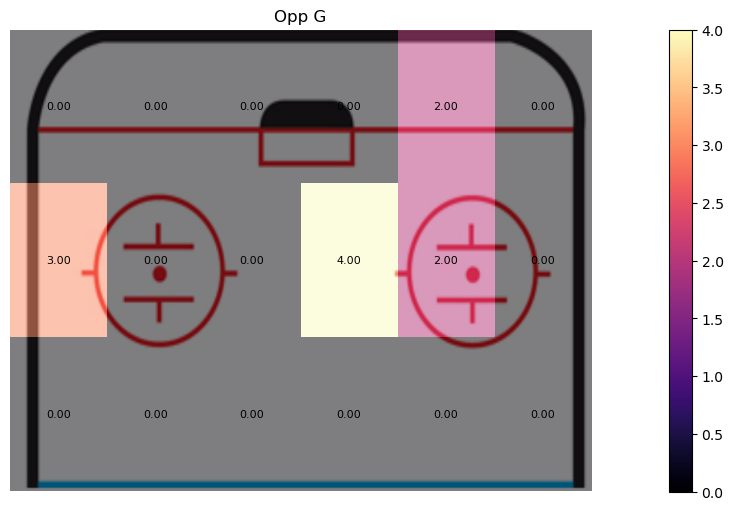

In [80]:
for value in ['Total Shots','Total Goals','MNA Shots', 'MNA G', 'Opp Shots', 'Opp G']:
    getZoneMap(agg_shots_areas, value, 'magma',offensive_zone_blank, 'nearest') #bilinear

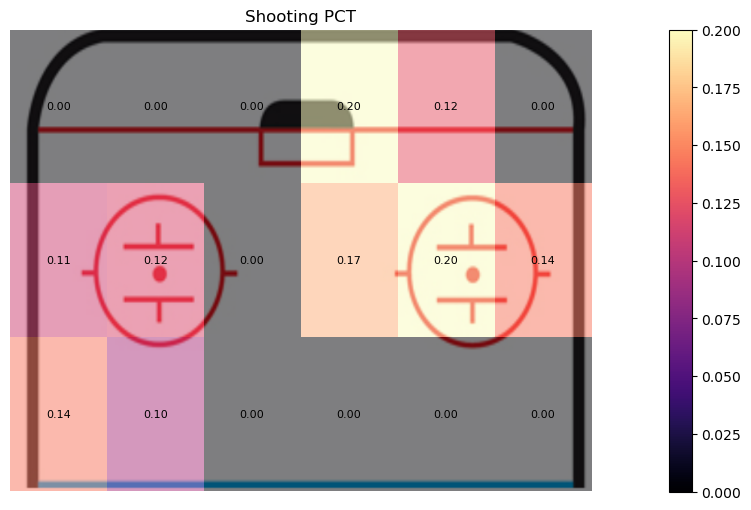

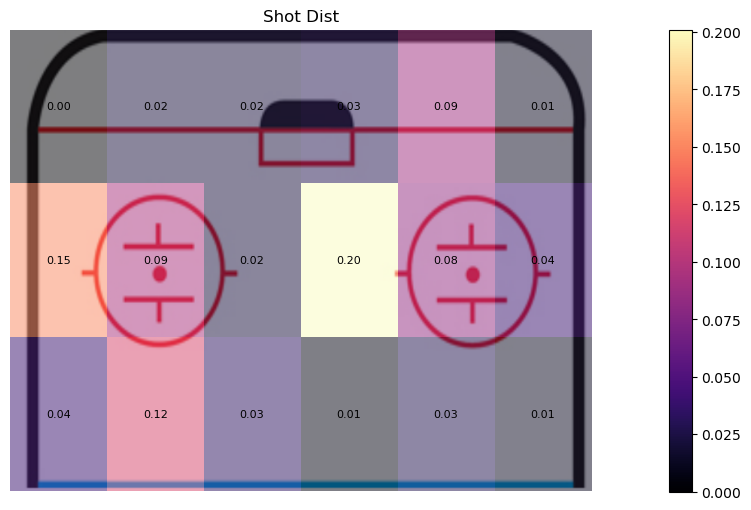

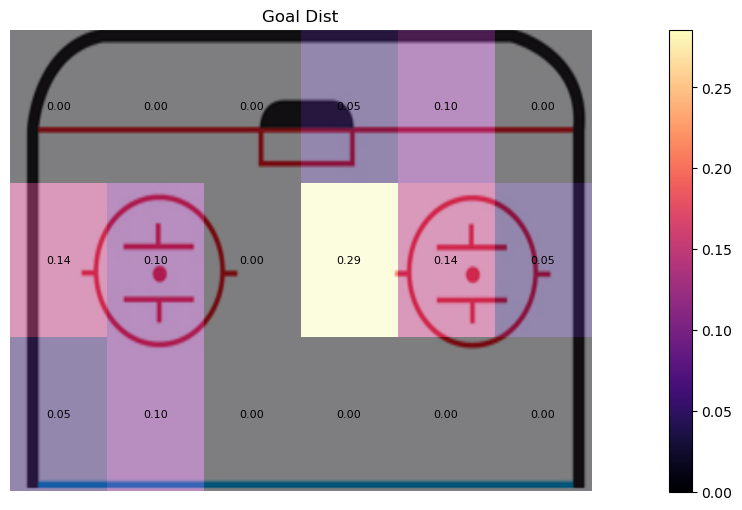

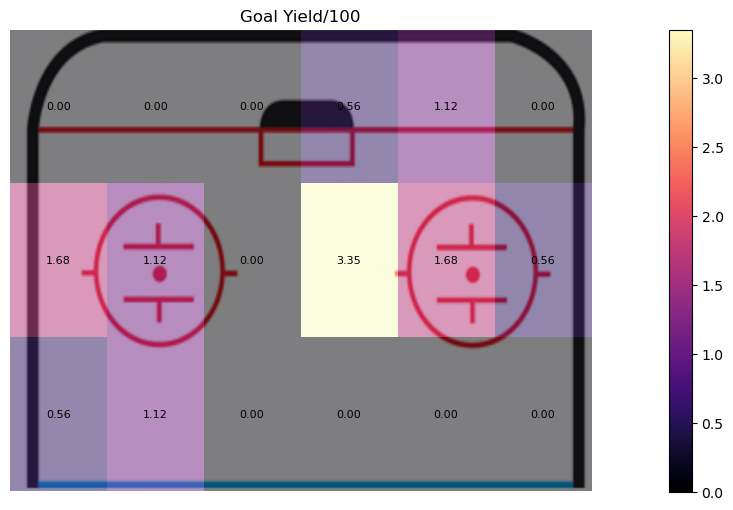

In [81]:
for value in ['Shooting PCT','Shot Dist', 'Goal Dist', 'Goal Yield/100']:
    getZoneMap(agg_shots_areas, value, 'magma',offensive_zone_blank, 'nearest') #bilinear

## World Championship Gameplay

Lets look at my performance during the championship games

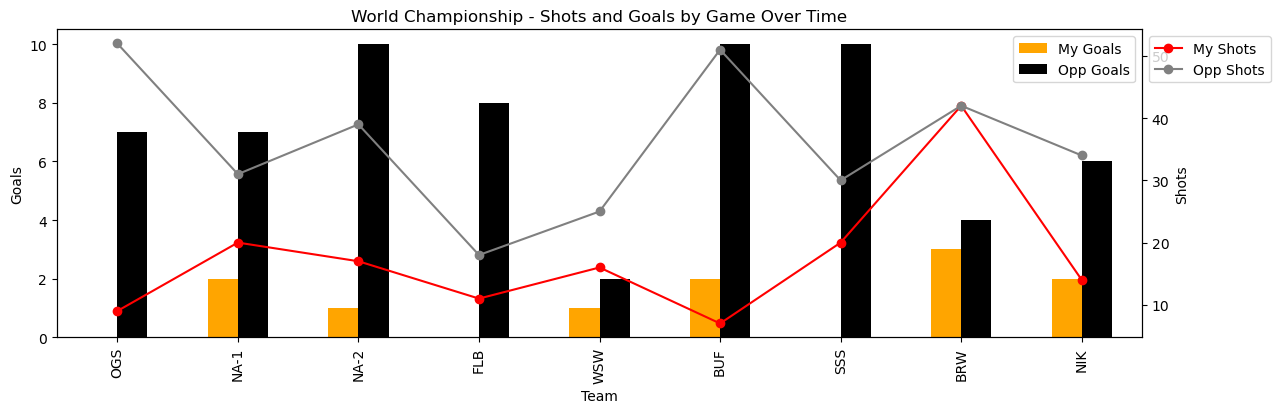

In [31]:
ax1 = wc.plot(kind = 'bar', y = ['MNA','Opp'], x = 'Team', figsize = (14,4), color = ['orange','black'], label = ['My Goals','Opp Goals'])
ax2 = ax1.twinx()
# Plot the second variable on the secondary y-axis
wc.plot(kind='line', y=['MNA Shots', 'Opp Shots'], ax=ax2, color=['red', 'grey'], marker='o', label=['My Shots', 'Opp Shots'])
# Set labels and legend
ax1.set_ylabel('Goals')
ax2.set_ylabel('Shots')
plt.title('World Championship - Shots and Goals by Game Over Time')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# Show the plot
plt.show()

You can see that I got beat pretty bad. Normally a 10 goal game in an NHL season is pretty rare and so is giving up 50 shots.

In [48]:
print('I was outshot by a ratio of: ',round(wc['Opp Shots'].sum()/wc['MNA Shots'].sum(),1),': 1')
print('I was outscored by a ratio of: ',round(wc['Opp'].sum()/wc['MNA'].sum(),1),': 1')

I was outshot by a ratio of:  2.1 : 1
I was outscored by a ratio of:  5.8 : 1


The two games I did ok in looked like this:

In [33]:
wc.query('Team in ["WSW","BRW"]')

Date Team                     Type  MNA  Opp  MNA Shots  Opp Shots  \
4 2024-01-13  WSW  World Championship 2024    1    2         16         25   
7 2024-01-13  BRW  World Championship 2024    3    4         42         42   

  Outcome       TOA  PASSING  FACEOFD  PIM  PPM  Win  MNA Shot %  Opp Shot %  \
4     SOL  05:06:00     0.69        5    0    2    0    0.062500    0.080000   
7       L  04:07:00     0.73        9    4   12    0    0.071429    0.095238   

   Goal Diff  
4         -1  
7         -1

I captured more game data here than I normally do. I didn't want to write down all of the stats, so I just took my most teams info down. In hindsight, I wish I documented power play goals. I will use this as a learning experience to begin tracking those.

Something that makes sense to normally do all of the time is look for correlations quickly. Its one line of code in python. Because my data set is only 10 games, these will carry little statistical significance, but it’s still worth looking at to help guide my analysis. All this is asking is if numbers move together (any direction) 


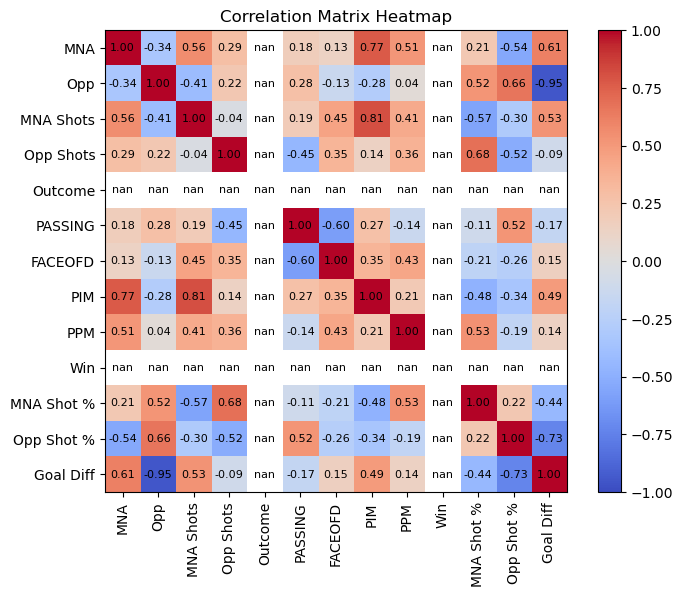

In [35]:
wc.Outcome = 0 
corr_matrix = wc[['MNA', 'Opp', 'MNA Shots', 'Opp Shots',
       'Outcome', 'PASSING', 'FACEOFD', 'PIM', 'PPM', 'Win',
       'MNA Shot %', 'Opp Shot %', 'Goal Diff']].corr()
# Create a heatmap
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)  # Adjust colormap and range based on your data
# Display colorbar for reference
plt.colorbar()
# Set x and y axis labels and ticks
plt.xticks(np.arange(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(np.arange(len(corr_matrix.index)), corr_matrix.index)
# Display values in each cell
for i in range(len(corr_matrix.index)):
    for j in range(len(corr_matrix.columns)):
        plt.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}', ha='center', va='center', color='black', fontsize=8)
# Set plot title
plt.title('Correlation Matrix Heatmap')
# Show the plot
plt.show()

My observations are as follows:
* Nothing correlates with winning because I never won...
* I am surprised that my goals correlate positively with my penalty minutes but my opponents’ goals do not correlate with my penalty minutes. This could mean a few things, but I am inclined to think it means I did well on my penalty kill
* I am surprised my passing completion % does not correlate with anything. This basically means that my passes being completed didn’t really influence a whole lot of key metrics. This could be because of the blow outs experiencd.


My opponents took quite a few penalties against me. That alone is a positive and means I was drawing penalties. In 6/9 games they had at least one. By just looking at this data I can tell that I didn't do a great job of converting on these chances without even looking into power play goals specifically.

In [36]:
wc.query('PPM > 0')

Date Team                     Type  MNA  Opp  MNA Shots  Opp Shots  \
3 2024-01-13  FLB  World Championship 2024    0    8         11         18   
4 2024-01-13  WSW  World Championship 2024    1    2         16         25   
5 2024-01-13  BUF  World Championship 2024    2   10          7         51   
6 2024-01-13  SSS  World Championship 2024    0   10         20         30   
7 2024-01-13  BRW  World Championship 2024    3    4         42         42   
8 2024-01-13  NIK  World Championship 2024    2    6         14         34   

   Outcome       TOA  PASSING  FACEOFD  PIM  PPM  Win  MNA Shot %  Opp Shot %  \
3        0  02:47:00     0.77        5    0    2    0         NaN    0.444444   
4        0  05:06:00     0.69        5    0    2    0    0.062500    0.080000   
5        0  05:15:00     0.72        5    0   12    0    0.285714    0.196078   
6        0  05:35:00     0.75        5    0    6    0         NaN    0.333333   
7        0  04:07:00     0.73        9    4   12    0    0.071429    0.095238   
8        0  03:19:00     0.72        5    2    2    0    0.142857    0.176471   

   Goal Diff  
3         -8  
4         -1  
5         -8  
6        -10  
7         -1  
8         -4

My interpertation, aided by these data, is that my powerplay needs to do a better job of not only producing offense, but also getting quality shots on net from high probability scoring areas. 

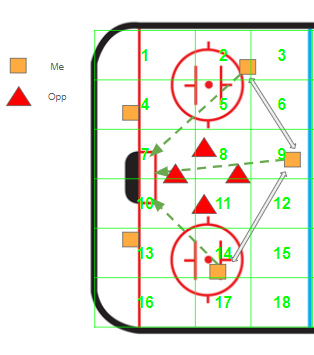

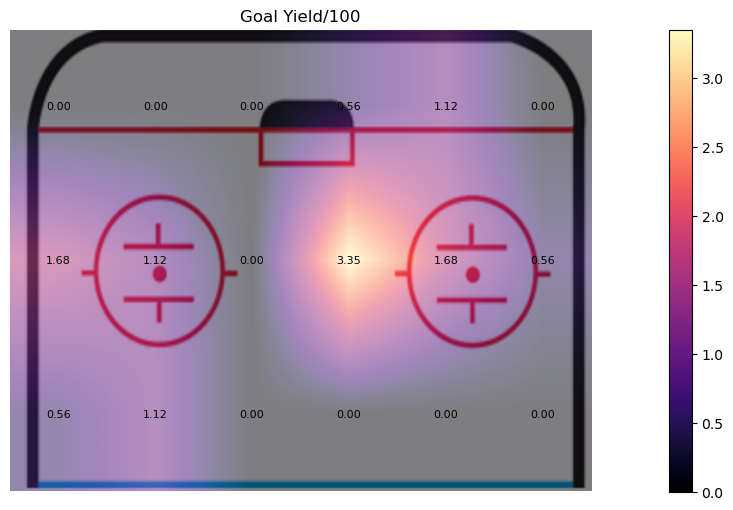

None

(None, None)

In [84]:
display(Image(filename=ppzones)), display(getZoneMap(agg_shots_areas, 'Goal Yield/100', 'magma',offensive_zone_blank, 'bilinear') )

Downside of the umbrella is that it pushes the shooters out a bit, as demonstrated in my original strategy with our zone concept overlaid. I need to make sure my shooters walk in just a little bit into high probability shooting lanes. Now we know where those are!

## Lessons Learned

My main takeaways are the following:
* I need to upskill my team to be competitive. This means implementing a renewed strategic approach towards leveling up my players or just playing into what EA wants and buy thems
    * My lines F3 and F4 are a liability right now in terms of skill. I need to focus here first. Hockey is a weak link sport so I am being limited by these 6 players
* I need to hold on to the puck for longer and walk in from the parameter. I take a lot of shots from above the circles and those don’t do me any favors most of the time. I could also put someone up front to screen the goalie. Ideally - I would shoot from between the circles or right in front of the net. When I am in a good scoring position, pick a corneome 
* Focus on my power play - this needs to improve to be a competency for me
* Revise breakout and defensive zone strategy. Because I know where high scoring areas are - I need to collapse in front of the net better and protect that space


## Implementation - Key Performance Indicators

It is going to take a bit of time to turn my team around and I might still get beat pretty bad. Lets focus on the things I can control and set some goals. 

* We know that when it comes to my team, lines 3 and 4 need to improve because right now their average skill is 81
* We need to pick our corners when shooting. Specifically target zones 1,2,6,18,19,20,23,24,30,32 when shooting
* Shoot from high probability zones. We know those are 4,5,6,7,8,9
* Get at least 16 shots on net for every goal I need inorder to at least score once so its not a shutout